In [1]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np

ref from https://github.com/ghliu/pytorch-ddpg/blob/master

In [2]:
class NormalizedAction(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
    
class NormalizedObservation(gym.ObservationWrapper):
    def observation(self, observation):
        d = self.observation_space.high - self.observation_space.low
        return ((observation - self.observation_space.low) / d) * 2 - 1

In [63]:
def myrender(self, title=''):
    plt.title(title)
    plt.imshow(self.old_render(mode='rgb_array'))
    plt.axis('off')
    plt.show()
    clear_output(wait=True)
    time.sleep(1/30)
    
def wrapper_gymenv(env):
    env = NormalizedAction(env)
    #env = NormalizedObservation(env)
    env.old_render = env.render
    env.render = lambda title='': myrender(env, title)
    return env

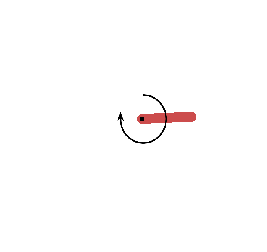

In [64]:
env = gym.make('Pendulum-v0')
env = wrapper_gymenv(env)
env.reset()
env.render()

In [5]:
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):
    def __init__(self, osize, asize, init_w=3e-3):
        super(Actor, self).__init__()
        
        self.osize = osize
        self.asize = asize
        
        self.main = nn.Sequential(
            nn.Linear(self.osize, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, self.asize),
            nn.Tanh(),
        )
        
        self.initweight(init_w)
    
    def initweight(self, init_w):
        count = 0
        for m in self.main.modules():
            if isinstance(m, nn.Linear):
                count += 1
                m.bias.data.fill_(0.0)
                if count < 3:
                    m.weight.data = fanin_init(m.weight.data.size())
                else:
                    m.weight.data.uniform_(-init_w, init_w)
        #print('actor init count '+str(count))
    
    def forward(self, x):
        out = self.main(x)
        return out

class Critic(nn.Module):
    def __init__(self, osize, asize, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.osize = osize
        self.asize = asize
        
        self.main1 = nn.Sequential(
            nn.Linear(self.osize, 400),
            nn.ReLU(inplace=True),
        )
        
        self.main2 = nn.Sequential(
            nn.Linear(400 + self.asize, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 1),
        )
        
        self.initweight(init_w)
    
    def initweight(self, init_w):
        count = 0
        for m in list(self.main1.modules()) + list(self.main2.modules()):
            if isinstance(m, nn.Linear):
                count += 1
                m.bias.data.fill_(0.0)
                if count < 3:
                    m.weight.data = fanin_init(m.weight.data.size())
                else:
                    m.weight.data.uniform_(-init_w, init_w)
        #print('critic init count '+str(count))
    
    def forward(self, x, a):
        out = self.main1(x)
        out = self.main2(torch.cat([out,a.reshape(-1,1)],1))
        return out

In [44]:
class Buffer():
    def __init__(self, osize, asize, size):
        self.osize = osize
        self.asize = asize
        # s , a, r, s'
        self.buffer = np.zeros( (size, osize + asize + 1 + osize + 1) )
        self.buffer_size = size
        self.buffer_count = 0
        
    def store(self, s, a, r, s_next, done):
        transition = np.hstack((s, [a, r], s_next, done))
        self.buffer[self.buffer_count%self.buffer_size, : ] = transition
        self.buffer_count += 1
        
    def miniBatch(self, batch_size):
        pick_i = np.random.choice(
            self.buffer_size if self.buffer_count > self.buffer_size else self.buffer_count, 
            size=batch_size
        )
        x = self.buffer[pick_i, :]
        
        return x[:, :self.osize], x[:, self.osize:self.osize + self.asize], x[:, self.osize+1].reshape(-1,1), x[:, -(self.osize+1):-1], x[:, -1].reshape(-1,1)

In [7]:
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta=0.15, mu=0., sigma=0.2, dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [51]:
device = torch.device("cuda:1")

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )

def to_tensor(ndarray, requires_grad=False):
    if device.type == 'cpu':
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
    
    return Variable(
        torch.from_numpy(ndarray), requires_grad=requires_grad
    ).type(dtype).to(device)

def to_numpy(var):
    return var.data.numpy() if device.type == 'cpu' else var.cpu().data.numpy() 

class DDPG(nn.Module):
    def __init__(
        self, observation_space, action_space
    ):
    
        super(DDPG, self).__init__()
    
        self.observation_space = observation_space
        self.action_space = action_space
    
        if len(observation_space.shape) > 0:
            self.osize = observation_space.shape[0]
        else:
            raise NotImplementedError()
            
        if len(action_space.shape) > 0:
            self.asize = action_space.shape[0]
        else:
            raise NotImplementedError()
        
        # u(s) -> dis of action
        self.actor = Actor(self.osize, self.asize).to(device)
        self.actor_ = Actor(self.osize, self.asize).to(device)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
    
        # Q(s, a) -> value
        self.critic = Critic(self.osize, self.asize).to(device)
        self.critic_ = Critic(self.osize, self.asize).to(device)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
    
        self.update()
        
        self.memory = Buffer(self.osize, self.asize, 10000)
        self.store = self.memory.store
        
        self.criterion = nn.MSELoss()
        
        self.random_process = OrnsteinUhlenbeckProcess(size=self.asize)
        
        self.metrics = []
        
        self.epsilon = 1.0
        self.depsilon = 1.0 / 50000
        
    def update(self, tau=None):
        if tau is None:
            self.actor_.load_state_dict(self.actor.state_dict())
            self.critic_.load_state_dict(self.critic.state_dict())
        else:
            soft_update(self.actor_, self.actor, tau)
            soft_update(self.critic_, self.critic, tau)
            
    def learn(self, batch_size, gamma=0.99):
        s, a, r, s_, done = self.memory.miniBatch(batch_size)

        with torch.no_grad():
            q_ = self.critic_(
                to_tensor(s_), 
                self.actor_(to_tensor(s_)) 
            )
        
        q_target = to_tensor(r) + ( gamma * to_tensor(1.0 - done.astype(np.float))*q_ )
        q_target = q_target.detach()
        
        # Critic learn
        self.critic_optim.zero_grad()
        
        #s = to_tensor(s)
        q = self.critic(
            to_tensor(s),
            to_tensor(a)
        )
        loss_value = self.criterion(q, q_target)
        loss_value.backward()
        
        self.critic_optim.step()
        
        # Actor learn
        self.actor_optim.zero_grad()
        
        loss_policy = -self.critic(
            to_tensor(s),
            self.actor(to_tensor(s))
        )
        
        loss_policy = loss_policy.mean()
        loss_policy.backward()
        
        self.actor_optim.step()
        
        self.update(tau=1e-3)
        
        return loss_value, loss_policy
    
    def random_think(self):
        action = np.random.uniform(-1.,1.,self.asize)
        return action
    
    def think(self, observation, use_epsilon=False):
        action = to_numpy(
            self.actor(to_tensor(np.array([observation])))
        ).squeeze(0)
        if use_epsilon:
            action += self.training*max(self.epsilon, 0)*self.random_process.sample()
            self.epsilon -= self.depsilon
        action = np.clip(action, -1., 1.)
        return action
    
    def reset(self):
        self.random_process.reset_states()

In [46]:
def play(agent, show=True):
    agent.eval()
    s = env.reset()
    score = 0.0
    while True:
        a = agent.think(s)
        
        s_, r, done, _ = env.step(a)
            #print(r)
        score += r
        
        if show:
            print('score : {}, state: {}, action: {}'.format(score, s, a))
            env.render()
            
        if done:
            break
        s = s_
    return score

In [47]:
def train(
    agent, epoch_size, batch_size
):
    
    for epoch in range(len(agent.metrics), epoch_size):
        # play
        
        observation = env.reset()
        score = 0.0
        step = 0
        
        loss_v_t = []
        loss_p_t = []
        
        agent.train()
        agent.reset()
        
        while True:
            
            if agent.memory.buffer_count <= 100:
                action = agent.random_think()
            else:
                action = agent.think(observation, True)
                
            # do action
            observation_next, reward, done, info = env.step(action)
            step += 1
            
            agent.store(observation, action, reward, observation_next, done)
            
            if agent.memory.buffer_count > 100:
                loss_value, loss_policy = agent.learn(batch_size)
                loss_v_t.append(loss_value.item())
                loss_p_t.append(loss_policy.item())
            
            # update state
            observation = observation_next
            
            if done:
                break
        
        test_score = np.mean([play(agent, show=False) for _ in range(100)])
        
        # metrics
        loss_v_t = np.average(loss_v_t) if len(loss_v_t) > 0 else 0.0
        loss_p_t = np.average(loss_p_t) if len(loss_p_t) > 0 else 0.0
            
        agent.metrics.append( (test_score, loss_v_t, loss_p_t) )
        
        clear_output(wait=True)
        print('#{:6.0f}: score : {:5.4f}'.format(epoch, test_score))

In [48]:
def evaluation(
    agent, eval_size
):
    scores = []
    for i in range(eval_size):
        scores.append( play(agent, show=False) )
    
    print('mean = {}, max = {}'.format(np.mean(scores), np.max(scores)))
    
    return scores

In [55]:
env = gym.make('Pendulum-v0')
env._max_episode_steps = 200
env = wrapper_gymenv(env)
torch.manual_seed(756110)
torch.cuda.manual_seed(756110)
env.seed(756110)
agent = DDPG(env.observation_space, env.action_space)

In [ ]:
%%time
train(agent, 3500, 64)

In [57]:
def showMetrics(agent):
    m = np.array(agent.metrics)
    
    plt.title('Total reward curve')
    plt.plot(m[:, 0])
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.show()
    
    plt.title('Loss curve')
    plt.plot(m[:, 1], label='value')
    plt.plot(m[:, 2], label='policy')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

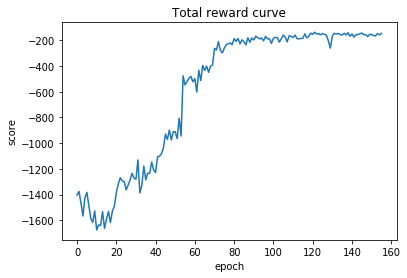

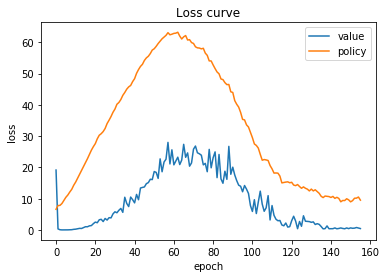

In [70]:
showMetrics(agent)

In [68]:
play(agent)

-140.3425701341182

In [69]:
_ = evaluation(agent, 100)

mean = -156.67449259580943, max = -11.31709859301885
